In [1]:
import tensorflow as tf
import os
import time
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import numpy as np
from nilearn import image
from nilearn import plotting
import nibabel as nib
from nilearn.plotting import plot_stat_map, plot_anat, plot_img

/localhome/mkhademi/anaconda3/envs/tf/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
data_dir = '/local-scratch/localhome/mkhademi/BOLD5000_2.0/'
batch_size = 37
#dataset = tf.data.TFRecordDataset(filenames = [data_dir + 'image_data/bold5000_coco.tfrecords']).batch(batch_size)
#dataset_size = 2135
dataset = tf.data.TFRecordDataset(filenames = [data_dir + 'image_data/bold5000_common.tfrecords']).batch(batch_size)
dataset_size = 2864
def tf_parse(eg):
    example = tf.io.parse_example(
        eg, {
            'x': tf.io.FixedLenFeature(shape=(71, 89, 72, 1), dtype=tf.float32),
            'yhat': tf.io.FixedLenFeature(shape=(1000), dtype=tf.float32),
            'y_coco': tf.io.FixedLenFeature(shape=(90), dtype=tf.int64),
            'y_imagenet': tf.io.FixedLenFeature(shape=(1000), dtype=tf.int64),
            'y_super': tf.io.FixedLenFeature(shape=(12), dtype=tf.int64),
            'y_common': tf.io.FixedLenFeature(shape=(90+12), dtype=tf.int64)
        })
    return example['x'], example['y_common'] 
n_it = 8
recalls = []
aucs = []
accs = []
recalls_rand = []
aucs_rand = []
accs_rand = []
for it in range(n_it):
    train_size_1 = np.ceil(dataset_size/batch_size*it/n_it)
    test_size = np.ceil(dataset_size/batch_size*1/n_it)
    train_ds_1 = dataset.take(train_size_1)
    test_ds = dataset.skip(train_size_1)
    test_ds = test_ds.take(test_size)
    train_ds_2 = dataset.skip(train_size_1 + test_size)
    train_size_2 = np.ceil(dataset_size/batch_size) - train_size_1 - test_size
    train_ds_2 = train_ds_2.take(train_size_2)
    train_ds = train_ds_1.concatenate(train_ds_2)
    train_ds = train_ds.unbatch().batch(10)
    train_ds = train_ds.shuffle(train_size_1 + train_size_2)
    train = train_ds.map(tf_parse)
    test = test_ds.map(tf_parse)
    train = train.map(lambda x, y: (x, tf.concat([y[:,91:92], tf.ones_like(y[:,91:92], dtype=tf.int64)-y[:,91:92]], axis=1))) 
    test = test.map(lambda x, y: (x, tf.concat([y[:,91:92], tf.ones_like(y[:,91:92], dtype=tf.int64)-y[:,91:92]], axis=1)))
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(71, 89, 72, 1)),
        tf.keras.layers.Conv3D(1, 3, activation='relu', padding='same', name='conv1'),
        #tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
        tf.keras.layers.Conv3D(2, 3, activation='relu', padding='same', name='conv2'),
        tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
        tf.keras.layers.Conv3D(4, 3, padding='same', name='conv3'),
        tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(rate=0.4),
        # tf.keras.layers.Dense(100, activation='sigmoid'),
        tf.keras.layers.Dense(2),
        #tf.keras.layers.Softmax()
        ])
    model.summary()
    model.compile(
        # loss='mse',
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        # loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
        # optimizer=keras.optimizers.RMSprop(),
        optimizer='adam',
        # metrics=[tf.keras.metrics.MeanSquaredError()],
        metrics=[tf.keras.metrics.CategoricalAccuracy()]
    )
    model.fit(train, epochs=50)
    _, acc = model.evaluate(test)
    model_rand = tf.keras.Sequential([
        tf.keras.Input(shape=(71, 89, 72, 1)),
        tf.keras.layers.Conv3D(1, 3, activation='relu', padding='same', name='conv1'),
        #tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
        tf.keras.layers.Conv3D(2, 3, activation='relu', padding='same', name='conv2'),
        tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
        tf.keras.layers.Conv3D(4, 3, padding='same', name='conv3'),
        tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(rate=0.4),
        # tf.keras.layers.Dense(100, activation='sigmoid'),
        tf.keras.layers.Dense(2),
        #tf.keras.layers.Softmax()
        ])
    model_rand.compile(
        # loss='mse',
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        # loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
        # optimizer=keras.optimizers.RMSprop(),
        optimizer='adam',
        # metrics=[tf.keras.metrics.MeanSquaredError()],
        metrics=[tf.keras.metrics.CategoricalAccuracy()]
    )
    train_rand = train.map(lambda x, y: (x, tf.random.shuffle(y)))
    model_rand.fit(train_rand, epochs=50)
    _, acc_rand = model_rand.evaluate(test)
    print(acc_rand)
    
    model.add(tf.keras.layers.Softmax())
    model_rand.add(tf.keras.layers.Softmax())
    m_recall = tf.keras.metrics.Recall()
    m_auc = tf.keras.metrics.AUC()
    m_recall_rand = tf.keras.metrics.Recall()
    m_auc_rand = tf.keras.metrics.AUC()
    m_acc_rand = tf.keras.metrics.CategoricalAccuracy()
    
    for x_batch, y_batch in test:
        yhat = model(x_batch)
        yhat_rand = model_rand(x_batch)
        m_recall.update_state(y_batch[:,0], yhat[:,0])
        m_auc.update_state(y_batch[:,0], yhat[:,0])
        m_recall_rand.update_state(y_batch[:,0], yhat_rand[:,0])
        m_auc_rand.update_state(y_batch[:,0], yhat_rand[:,0])
        m_acc_rand.update_state(y_batch, yhat_rand)
    recalls.append(m_recall.result().numpy())
    aucs.append(m_auc.result().numpy())
    accs.append(acc)
    recalls_rand.append(m_recall_rand.result().numpy())
    aucs_rand.append(m_auc_rand.result().numpy())
    accs_rand.append(m_acc_rand.result().numpy())
print(recalls)
print(aucs)
print(accs)
print(recalls_rand)
print(aucs_rand)
print(accs_rand)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 71, 89, 72, 1)     28        
_________________________________________________________________
conv2 (Conv3D)               (None, 71, 89, 72, 2)     56        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 35, 44, 36, 2)     0         
_________________________________________________________________
conv3 (Conv3D)               (None, 35, 44, 36, 4)     220       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 17, 22, 18, 4)     0         
_________________________________________________________________
flatten (Flatten)            (None, 26928)             0         
_________________________________________________________________
dropout (Dropout)            (None, 26928)             0

In [3]:
raw_example = next(iter(test_ds))
print(tf_parse(raw_example)[0].numpy().shape)
print(tf_parse(raw_example)[1].numpy().shape)
print(tf_parse(raw_example)[1].numpy().sum(axis=1))
for x,y in test.take(1):
    print(x.shape, y.shape) 

(37, 71, 89, 72, 1)
(37, 102)
[ 3  2  2  3  3  2  9  2  2  2  2  2  2  2  2  2  3  2  3  2 10  2  2  2
  6  2  6  4  1  2  9  4  2  2  2  2  4]
(37, 71, 89, 72, 1) (37, 2)


In [4]:
img4d = image.load_img(data_dir + 'CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-01.nii.gz');
selected_volumes = image.index_img(img4d, slice(200, 201))
imgs = [img for img in image.iter_img(selected_volumes)]
img = imgs[0]
mask = np.zeros(img.shape) * image.get_data(img)
# plot_stat_map(img, threshold='auto', display_mode="z", cut_coords=4, bg_img=None)

In [5]:
for x_batch, y_batch in test.take(1):
    pass
x_var = tf.Variable(x_batch, dtype=tf.float32)

with tf.GradientTape() as tape0:
    preds0 = model(x_var)[:,0]
print(preds0.shape)
grads0 = tape0.gradient(preds0, x_var)
print(grads0.numpy().shape)
print(grads0.numpy().sum())

with tf.GradientTape() as tape1:
    preds1 = model(x_var)[:,1]
print(preds1.shape)
grads1 = tape1.gradient(preds1, x_var)
print(grads1.numpy().shape)
print(grads1.numpy().sum())

with tf.GradientTape() as tape:
    preds = model(x_var)
batch_jacobian = tape.batch_jacobian(preds, x_var)
print(batch_jacobian.numpy().shape)
print(batch_jacobian.numpy()[:,0,:,:,:,:].sum())
print(batch_jacobian.numpy()[:,1,:,:,:,:].sum())

@tf.function
def f(x_batch):
    with tf.GradientTape(persistent=True) as tape:
            tape.watch(x_batch)
            preds = model(x_batch)
    batch_jacobian = tape.batch_jacobian(preds, x_batch)
    return batch_jacobian

(37,)
(37, 71, 89, 72, 1)
-1.7907192
(37,)
(37, 71, 89, 72, 1)
1.7907184
(37, 2, 71, 89, 72, 1)
-1.7907186
1.7907177


/localhome/mkhademi/anaconda3/envs/tf/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


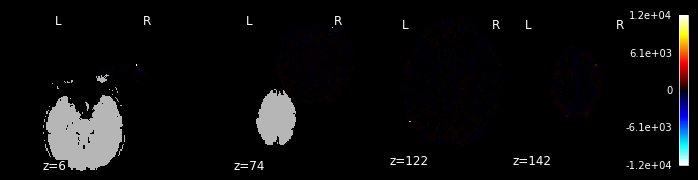

In [6]:
brain_mask = image.load_img(data_dir + 'CSI1_brainmask.nii.gz');
plot_stat_map(img, threshold='auto', display_mode="z", cut_coords=4, bg_img=brain_mask)

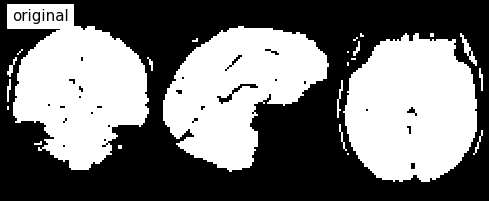

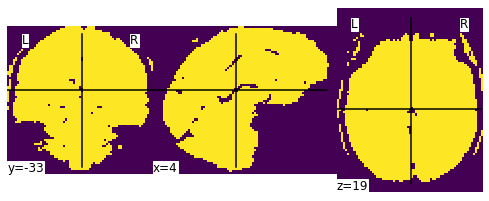

In [7]:
anat = data_dir + 'CSI1_brainmask.nii.gz'  
plot_anat(anat, title='original', display_mode='ortho', dim=-1, draw_cross=False, annotate=False)
plot_img(anat)

In [8]:
from nilearn import datasets
print('Datasets are stored in: %r' % datasets.get_data_dirs())
motor_images = datasets.fetch_neurovault_motor_task()
motor_images.images
tmap_filename = motor_images.images[0]
# plot_stat_map(tmap_filename)
# plot_stat_map(tmap_filename, threshold=3)

Datasets are stored in: ['/localhome/mkhademi/nilearn_data']


In [9]:
img_data = np.array(img.dataobj)
print(np.max(img_data))
print(np.min(img_data))

9611.976
-12267.824


In [10]:
vis_output = model.get_layer('conv1').output
print(vis_output.shape)
vis_model = tf.keras.models.Model(inputs=model.input, outputs=vis_output)
vis_face = np.zeros(vis_output.shape[1:4])
vis_noface = np.zeros(vis_output.shape[1:4])
count_face = 0
count_noface = 0
for x_batch, y_batch in train:
    output = vis_model.predict(x_batch)
    for i in range(y_batch.shape[0]):
        if y_batch[i][0] == 1:
            vis_face += output[i][:,:,:,0] 
            count_face += 1
        else:
            vis_noface += output[i][:,:,:,0]
            count_noface += 1
                      
print(count_face)
print(count_noface)
vis_face = vis_face/count_face 
vis_noface = vis_noface/count_noface 
# print(vis_face) 
print(np.max(vis_face))
print(np.min(vis_face))

(None, 71, 89, 72, 1)
417
2099
2767.4374982398763
0.0


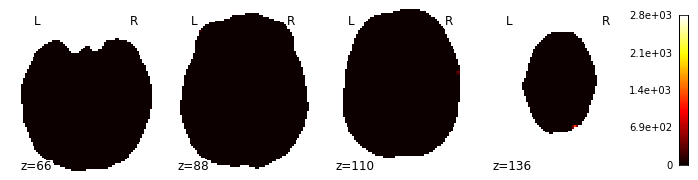

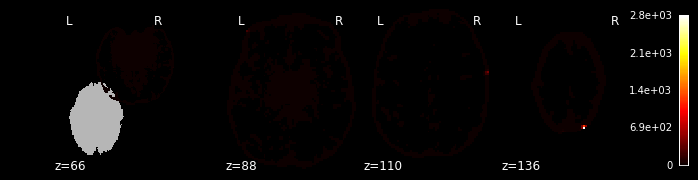

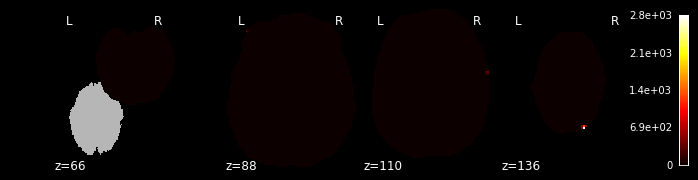

In [11]:
vis_face += mask
vis_noface += mask

nifti_file = nib.nifti1.Nifti1Image(dataobj=vis_face, affine=img.affine, header=img.header, extra=None, file_map=None)
plot_stat_map(nifti_file, threshold=0, display_mode="z", cut_coords=4, bg_img=None)

plot_stat_map(nifti_file, threshold='auto', display_mode="z", cut_coords=4, bg_img=brain_mask)
plot_stat_map(nifti_file, threshold=0, display_mode="z", cut_coords=4, bg_img=brain_mask)

In [12]:
vis_face = np.zeros(x_batch.shape[1:4])
vis_noface = np.zeros(x_batch.shape[1:4])
vis_face2 = np.zeros(x_batch.shape[1:4])
vis_noface2 = np.zeros(x_batch.shape[1:4])
count_face = 0
count_noface = 0
for x_batch, y_batch in train:
    batch_jacobian = f(x_batch) # (20, 2, 71, 89, 72, 1)
    for i in range(y_batch.shape[0]):
        if y_batch[i][0] == 1:
            vis_face += np.absolute(batch_jacobian.numpy()[i,0,:,:,:,0]) 
            vis_face2 += batch_jacobian.numpy()[i,0,:,:,:,0]
            count_face += 1
        else:
            vis_noface += np.absolute(batch_jacobian.numpy()[i,1,:,:,:,0])
            vis_noface2 += batch_jacobian.numpy()[i,1,:,:,:,0]
            count_noface += 1
print(count_face)
print(count_noface)
vis_face = vis_face/count_face 
vis_noface = vis_noface/count_noface 
vis_face2 = vis_face2/count_face 
vis_noface2 = vis_noface2/count_noface 
# print(vis_face) 
print(np.max(vis_face))
print(np.min(vis_face))

417
2099
0.0017699236312882461
0.0


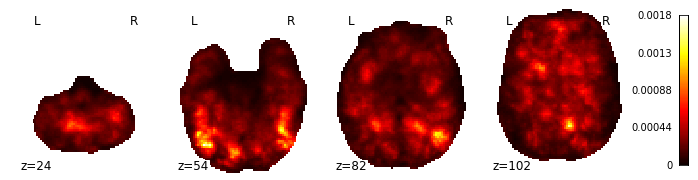

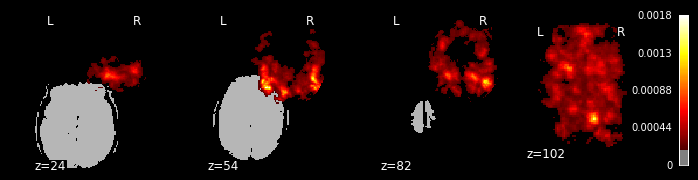

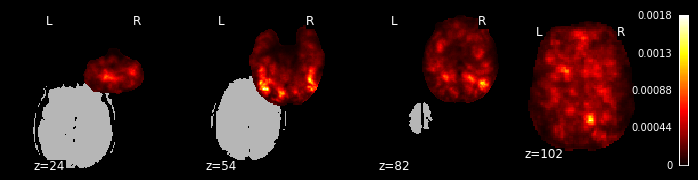

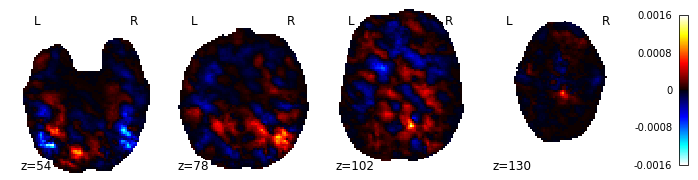

In [13]:
vis_face += mask
vis_noface += mask
vis_face2 += mask
vis_noface2 += mask
diff = vis_face2 - vis_noface2
diff += mask

nifti_file = nib.nifti1.Nifti1Image(dataobj=vis_face, affine=img.affine, header=img.header, extra=None, file_map=None)
plot_stat_map(nifti_file, threshold=0, display_mode="z", cut_coords=4, bg_img=None)

plot_stat_map(nifti_file, threshold='auto', display_mode="z", cut_coords=4, bg_img=brain_mask)
plot_stat_map(nifti_file, threshold=0, display_mode="z", cut_coords=4, bg_img=brain_mask)

nifti_file = nib.nifti1.Nifti1Image(dataobj=diff, affine=img.affine, header=img.header, extra=None,file_map=None)
plot_stat_map(nifti_file, threshold=0, display_mode="z", cut_coords=4, bg_img=None)

In [14]:
pos = 0
neg = 0
for x_batch, y_batch in test:
    for i in range(y_batch.shape[0]):
        if y_batch[i][0] == 1:
            pos += 1
        else:
            neg += 1
print(pos)
print(neg)
pos = 0
neg = 0
for x_batch, y_batch in train:
    for i in range(y_batch.shape[0]):
        if y_batch[i][0] == 1:
            pos += 1
        else:
            neg += 1
print("train set:")
print(pos)
print(neg)

65
283
train set:
417
2099


In [15]:
batch_size = 20
dataset = tf.data.TFRecordDataset(filenames = [data_dir + 'image_data/bold5000_common.tfrecords']).batch(batch_size)
train_ds = dataset.take((2135+400)//batch_size)
test_ds = dataset.skip((2135+400)//batch_size)
test_ds = test_ds.take(329//batch_size)
train_ds = train_ds.shuffle(2135+400)

In [16]:
def tf_parse(eg):
    example = tf.io.parse_example(
        eg, {
            'x': tf.io.FixedLenFeature(shape=(71, 89, 72, 1), dtype=tf.float32),
            'yhat': tf.io.FixedLenFeature(shape=(1000), dtype=tf.float32),
            'y_coco': tf.io.FixedLenFeature(shape=(90), dtype=tf.int64),
            'y_imagenet': tf.io.FixedLenFeature(shape=(1000), dtype=tf.int64),
            'y_super': tf.io.FixedLenFeature(shape=(12), dtype=tf.int64),
            'y_common': tf.io.FixedLenFeature(shape=(90+12), dtype=tf.int64),
        })
    return example['x'], example['y_super']
    
decoded = train_ds.map(tf_parse)
decoded_test = test_ds.map(tf_parse)

In [17]:
raw_example = next(iter(test_ds))
print(tf_parse(raw_example)[0].numpy().shape)
print(tf_parse(raw_example)[1].numpy().shape)
print(tf_parse(raw_example)[1].numpy().sum(axis=1))

(20, 71, 89, 72, 1)
(20, 12)
[1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1]


In [18]:
for x_batch, y_batch in decoded_test.take(1):
    print(x_batch.shape)

(20, 71, 89, 72, 1)


In [19]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(71, 89, 72, 1)),
    tf.keras.layers.Conv3D(1, 3, activation='relu', padding='same', name='conv1'),
    # tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(2, 3, padding='same', name='conv2'),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(4, 3, padding='same', name='conv3'),
    # tf.keras.layers.Conv3D(2, 3, activation='relu', padding='same', name='conv3'),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(12, activation='sigmoid'),
    # tf.keras.layers.Softmax()
    ])
 
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 71, 89, 72, 1)     28        
_________________________________________________________________
conv2 (Conv3D)               (None, 71, 89, 72, 2)     56        
_________________________________________________________________
max_pooling3d_32 (MaxPooling (None, 35, 44, 36, 2)     0         
_________________________________________________________________
conv3 (Conv3D)               (None, 35, 44, 36, 4)     220       
_________________________________________________________________
max_pooling3d_33 (MaxPooling (None, 17, 22, 18, 4)     0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 26928)             0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 26928)           

In [20]:
model.compile(
    # loss='mse',
    # loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
    # optimizer=keras.optimizers.RMSprop(),
    optimizer='adam',
    # metrics=[tf.keras.metrics.MeanSquaredError()],
    # metrics=[tf.keras.metrics.CategoricalAccuracy()],
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)
#model.fit(decoded, epochs=60)

In [21]:
loss, accuracy = model.evaluate(decoded_test)

16/16 [==============================] - 4s 46ms/step - loss: 12.9412 - binary_accuracy: 0.4471


In [22]:
for x_batch, y_batch in decoded_test.take(1):
    #print(tf.keras.activations.sigmoid(model(x_batch)))
    print(model(x_batch))

tf.Tensor(
[[8.8116661e-02 8.6407983e-01 2.5899296e-03 1.0000000e+00 6.6314050e-07
  9.9998140e-01 2.7935634e-05 5.9203464e-01 9.9999964e-01 9.2352904e-02
  1.0000000e+00 1.0000000e+00]
 [1.9138794e-14 9.9763227e-01 1.0000000e+00 1.0000000e+00 1.8918904e-04
  1.0000000e+00 1.6734912e-04 2.1469443e-05 1.0000000e+00 2.7259082e-01
  9.9984610e-01 9.9964666e-01]
 [5.5490437e-07 1.0000000e+00 9.9900961e-01 1.0000000e+00 1.4823587e-01
  6.2911515e-03 7.4460968e-07 9.9782443e-01 1.0000000e+00 1.8064319e-09
  9.9999988e-01 6.1475475e-05]
 [3.7514318e-03 5.5358815e-03 9.9749446e-01 1.0000000e+00 9.9850935e-01
  9.9998879e-01 4.2302353e-10 9.9721223e-01 9.9654323e-01 1.5230886e-04
  9.9996185e-01 7.9953283e-01]
 [1.8244906e-12 4.1926146e-08 9.9999952e-01 1.0000000e+00 9.9997854e-01
  1.0000000e+00 9.5046144e-06 9.9952531e-01 9.2741060e-01 1.0108373e-01
  9.9936992e-01 9.9998152e-01]
 [2.4518765e-06 4.8720490e-02 1.0000000e+00 1.0000000e+00 1.0000000e+00
  1.0000000e+00 2.1661362e-12 9.9999988e-0